In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Piauí - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PI.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - Consumo de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,21.844,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,15.814,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,16.067,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,14.938,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,17.765,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


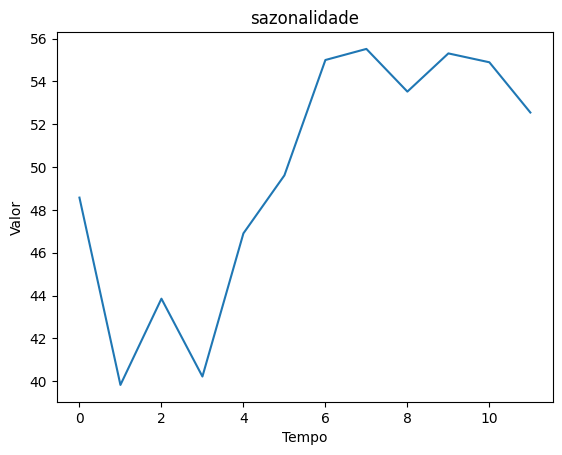

,sazonalidade
sazonalidade,
0,48.574097
1,39.828649
2,43.855074
3,40.221108
4,46.904934
5,49.613324
6,54.999276
7,55.516575
8,53.523642


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266,48.574097,21.844
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156,39.828649,15.814
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046,43.855074,16.067
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937,40.221108,14.938
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827,46.904934,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.904934,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.613324,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.999276,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.516575,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Piauí - Consumo de Cimento (t), Length: 249, dtype: float64

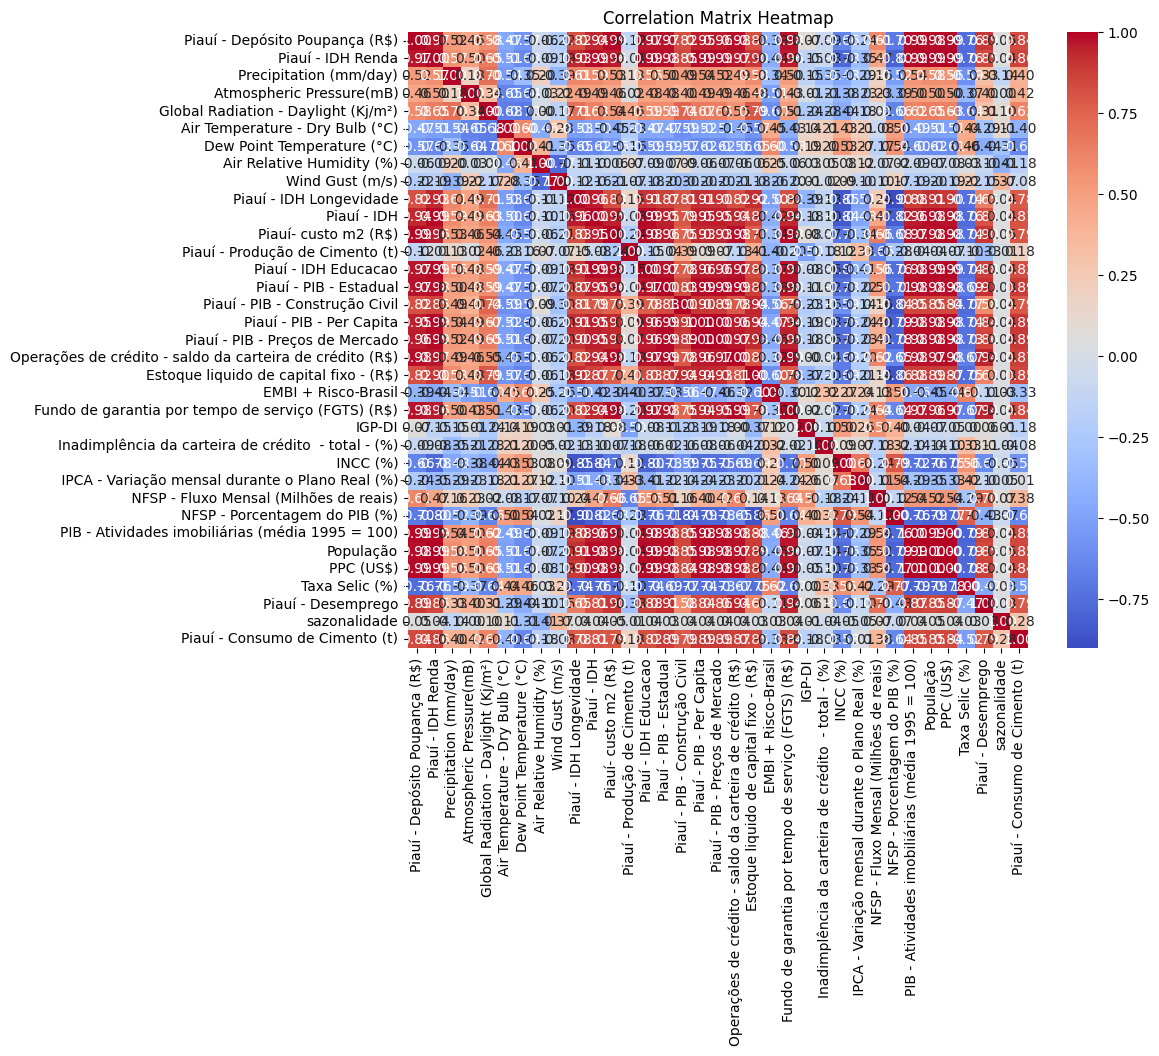

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Piauí - Depósito Poupança (R$),5.176430e+04
1,Piauí - IDH Renda,1.563030e+08
2,Precipitation (mm/day),3.921258e+01
3,Atmospheric Pressure(mB),9.925387e+06
4,Global Radiation - Daylight (Kj/m²),1.276249e+02
5,Air Temperature - Dry Bulb (°C),5.580874e+04
6,Dew Point Temperature (°C),1.598113e+04
7,Air Relative Humidity (%),1.337105e+04
8,Wind Gust (m/s),4.556565e+02
9,Piauí - IDH Longevidade,4.042950e+09


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)',
                 'Inadimplência da carteira de crédito  - total - (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,1.392136e+06,0.578335,0.572145,619.438209,29.774322,22.498674,65.288728,1.531145,9410.948400,24.669760,2.136063e+07,1.358044e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,8.192266,48.574097
1,1.402507e+06,0.578959,0.575756,621.987667,29.768728,22.492857,65.296204,1.530215,9501.490708,25.167145,2.139102e+07,1.359835e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,8.186156,39.828649
2,1.412879e+06,0.579583,0.577863,623.474852,29.765464,22.489463,65.300565,1.529673,9582.303300,25.520404,2.142142e+07,1.361626e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,8.180046,43.855074
3,1.423251e+06,0.580207,0.578089,623.634193,29.765115,22.489100,65.301032,1.529614,9659.062943,25.519725,2.145181e+07,1.363417e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,8.173937,40.221108
4,1.433623e+06,0.580831,0.565428,593.257336,29.985428,22.815550,65.747286,1.500524,9730.815357,25.929312,2.148221e+07,1.365208e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,8.167827,46.904934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,4.581639e+06,0.648012,1.126722,1298.592639,28.369735,19.153206,61.612685,1.323023,26786.449027,14.891698,2.614226e+07,1.442652e+06,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,10.937592,55.516575
200,4.666211e+06,0.647940,1.160958,1302.681359,28.842994,19.211830,60.268505,1.381048,26985.303083,14.751425,2.611104e+07,1.443030e+06,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,10.926398,53.523642
201,4.750784e+06,0.647868,1.298432,1271.389072,28.756708,19.640899,62.034942,1.371059,27186.067192,14.619163,2.607981e+07,1.443408e+06,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,10.915204,55.307412
202,4.835357e+06,0.647796,1.802055,1233.378305,28.430406,20.268319,65.393942,1.292689,27393.940041,14.493339,2.604859e+07,1.443786e+06,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,10.904010,54.893086


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,-2.101903,-0.870563,-0.945536,0.418510,0.360124,-0.243336,1.069892,-1.555279,-1.018917,-1.729819,-2.582588,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141,-0.809551
1,-2.073276,-0.866769,-0.940378,0.416036,0.357857,-0.242480,1.065891,-1.537623,-0.975562,-1.712781,-2.513990,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904,-0.813964
2,-2.044649,-0.864555,-0.937369,0.414593,0.356535,-0.241981,1.063557,-1.521865,-0.944770,-1.695744,-2.445392,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828,-0.818378
3,-2.016022,-0.864318,-0.937047,0.414438,0.356393,-0.241927,1.063307,-1.506897,-0.944830,-1.678707,-2.376794,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354,-0.822791
4,-1.987394,-0.877621,-0.998507,0.511873,0.483624,-0.190832,0.938142,-1.492905,-0.909128,-1.661670,-2.308196,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281,-0.827205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.094555,-0.287829,0.428568,-0.202674,-0.943738,-0.664238,0.174426,1.832942,-1.871221,0.950522,0.658322,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268,1.173652
200,1.091258,-0.251855,0.436841,0.006627,-0.920890,-0.818145,0.424086,1.871719,-1.883448,0.933020,0.672807,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925,1.165565
201,1.087962,-0.107402,0.373529,-0.031534,-0.753665,-0.615890,0.381105,1.910868,-1.894976,0.915517,0.687292,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663,1.157479
202,1.084665,0.421792,0.296623,-0.175842,-0.509134,-0.231289,0.043911,1.951403,-1.905944,0.898015,0.701777,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340,1.149393


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,-2.101903,-0.870563,-0.945536,0.418510,0.360124,-0.243336,1.069892,-1.555279,-1.018917,-1.729819,-2.582588,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141,-0.809551
1,-2.073276,-0.866769,-0.940378,0.416036,0.357857,-0.242480,1.065891,-1.537623,-0.975562,-1.712781,-2.513990,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904,-0.813964
2,-2.044649,-0.864555,-0.937369,0.414593,0.356535,-0.241981,1.063557,-1.521865,-0.944770,-1.695744,-2.445392,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828,-0.818378
3,-2.016022,-0.864318,-0.937047,0.414438,0.356393,-0.241927,1.063307,-1.506897,-0.944830,-1.678707,-2.376794,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354,-0.822791
4,-1.987394,-0.877621,-0.998507,0.511873,0.483624,-0.190832,0.938142,-1.492905,-0.909128,-1.661670,-2.308196,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281,-0.827205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.124775,0.212274,0.390648,-0.112197,-0.710681,-0.724978,0.124133,1.483643,-1.653101,1.122679,0.480726,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820,1.236675
188,1.123346,0.805763,0.355230,-0.053134,-0.566168,-0.630714,0.219290,1.505143,-1.676911,1.112751,0.495966,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503,1.235391
189,1.121918,0.757769,0.306991,-0.068732,-0.349387,-0.388438,0.133147,1.527356,-1.699764,1.102823,0.511206,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444,1.234108
190,1.120489,0.996984,0.220550,-0.178855,-0.105828,-0.021613,-0.203063,1.551068,-1.721624,1.092895,0.526446,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935,1.232824


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
187    77.652
188    84.626
189    78.907
190    70.813
191    71.072
Name: Piauí - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego
156,1.229258,0.452460,0.159733,-0.285872,-0.104355,0.316076,-0.212582,0.887046,-0.010568,1.124753,0.305787,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265,1.365965
157,1.223332,0.541461,0.147867,-0.363566,0.080643,0.554884,-0.576030,0.903652,-0.076736,1.131062,0.306033,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084,1.364113
158,1.217406,0.696615,0.104153,-0.452076,0.076280,0.607976,-0.721067,0.920511,-0.143298,1.137372,0.306279,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087,1.362260
159,1.211479,0.371166,0.151194,-0.511931,-0.213287,0.342519,-0.721638,0.937968,-0.210535,1.143682,0.306526,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300,1.360408
160,1.205553,0.022990,0.203630,-0.484109,-0.626589,-0.106108,-0.579217,0.955244,-0.278455,1.149992,0.306772,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403,1.358555
161,1.199627,-0.041070,0.303038,-0.321172,-1.024473,-0.637169,-0.150340,0.972087,-0.347072,1.156301,0.307018,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434,1.356703
162,1.193700,0.020032,0.399236,-0.078444,-1.360543,-1.137520,0.281856,0.990012,-0.416380,1.162611,0.307264,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553,1.354850
163,1.187774,0.071945,0.458821,0.245316,-1.471232,-1.490136,0.750485,1.008653,-0.486399,1.168921,0.307510,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038,1.352998
164,1.181848,0.214387,0.424941,0.407927,-1.394548,-1.558317,1.052221,1.028223,-0.557138,1.175231,0.307756,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412,1.351145
165,1.175921,0.062743,0.365166,0.354880,-1.236536,-1.367556,1.063679,1.048628,-0.628615,1.181540,0.308002,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764,1.349293


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2974881738, 666397267, 2713638356, 1860267535, 3932166746, 2502206014, 4257493555, 2875997487, 3356153282, 1360088703]


Step: 0 ___________________________________________
val_loss: 181.26983642578125
winner_seed: 2974881738


Step: 1 ___________________________________________
val_loss: 150.55494689941406
winner_seed: 666397267


Step: 2 ___________________________________________
val_loss: 99.07738494873047
winner_seed: 2713638356


Step: 3 ___________________________________________
val_loss: 141.4170379638672


Step: 4 ___________________________________________
val_loss: 119.39157104492188


Step: 5 ___________________________________________
val_loss: 119.71994018554688


Step: 6 ___________________________________________
val_loss: 151.25975036621094


Step: 7 ___________________________________________
val_loss: 147.6265869140625


Step: 8 ___________________________________________
val_loss: 97.76960754394531
winner_seed: 3356153282


Step: 9 ________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3430781553

Epoch 1/10000
5/5 [==============================] - 2s 98ms/step - loss: 2681.0271 - val_loss: 190.7166
Epoch 2/10000
5/5 [==============================] - 0s 9ms/step - loss: 240.7221 - val_loss: 182.5555
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 219.4889 - val_loss: 204.7504
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 198.3294 - val_loss: 217.1077
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 156.6462 - val_loss: 207.3903
Epoch 6/10000
5/5 [==============================] - 0s 9ms/step - loss: 115.7603 - val_loss: 259.0255
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 167.9702 - val_loss: 174.6919
Epoch 8/10000
5/5 [==============================] - 0s 8ms/step - loss: 90.1396 - val_loss: 570.3776
Epoch 9/10000
5/5 [==============================] - 0s 8ms/step - loss: 128.9664 - val_loss: 192.8954
Epoch 10/10000
5/5 [==============================] - 0s 9ms/step - lo

5/5 [==============================] - 0s 9ms/step - loss: 31.5485 - val_loss: 223.5506
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 41.4327 - val_loss: 151.5376
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 55.4084 - val_loss: 363.3427
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 34.6619 - val_loss: 322.4086
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 38.4885 - val_loss: 277.7027
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 32.2220 - val_loss: 211.2541
Epoch 86/10000
5/5 [==============================] - 0s 8ms/step - loss: 26.6703 - val_loss: 242.9368
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 29.7923 - val_loss: 227.4638
Epoch 88/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.6773 - val_loss: 243.7602
Epoch 89/10000
5/5 [==============================] - 0s 8ms/step - loss: 33.7080 - val_

Epoch 159/10000
5/5 [==============================] - 0s 9ms/step - loss: 23.6784 - val_loss: 264.2979
Epoch 160/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.7473 - val_loss: 231.9066
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.3677 - val_loss: 248.0661
Epoch 162/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.1376 - val_loss: 178.6665
Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 23.9651 - val_loss: 180.9240
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.3966 - val_loss: 172.7616
Epoch 165/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.2006 - val_loss: 260.4310
Epoch 166/10000
5/5 [==============================] - 0s 9ms/step - loss: 20.4061 - val_loss: 178.4901
Epoch 167/10000
5/5 [==============================] - 0s 8ms/step - loss: 22.7747 - val_loss: 181.4677
Epoch 168/10000
5/5 [==============================] - 0s 9ms

5/5 [==============================] - 0s 10ms/step - loss: 21.3950 - val_loss: 215.0918
Epoch 238/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.5715 - val_loss: 241.3210
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.7567 - val_loss: 184.7641
Epoch 240/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.3272 - val_loss: 247.8587
Epoch 241/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.2095 - val_loss: 228.6036
Epoch 242/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.1153 - val_loss: 190.3417
Epoch 243/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.1374 - val_loss: 269.3322
Epoch 244/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.1311 - val_loss: 411.6552
Epoch 245/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.6881 - val_loss: 160.2121
Epoch 246/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.5

5/5 [==============================] - 0s 9ms/step - loss: 20.2063 - val_loss: 214.3845
Epoch 316/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.7138 - val_loss: 260.0113
Epoch 317/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.6946 - val_loss: 233.0818
Epoch 318/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.9253 - val_loss: 294.5975
Epoch 319/10000
5/5 [==============================] - 0s 8ms/step - loss: 20.5652 - val_loss: 254.2327
Epoch 320/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.5827 - val_loss: 254.9140
Epoch 321/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.4898 - val_loss: 228.4114
Epoch 322/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.2125 - val_loss: 249.0176
Epoch 323/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.9376 - val_loss: 277.1783
Epoch 324/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.

5/5 [==============================] - 0s 9ms/step - loss: 17.1340 - val_loss: 224.2419
Epoch 394/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.4343 - val_loss: 260.2981
Epoch 395/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.8745 - val_loss: 223.6961
Epoch 396/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.2608 - val_loss: 215.9184
Epoch 397/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.3406 - val_loss: 179.4010
Epoch 398/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.4126 - val_loss: 208.2664
Epoch 399/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.0808 - val_loss: 179.3447
Epoch 400/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.6968 - val_loss: 244.7788
Epoch 401/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.3925 - val_loss: 217.5747
Epoch 402/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.

5/5 [==============================] - 0s 9ms/step - loss: 15.9476 - val_loss: 308.2335
Epoch 472/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.1915 - val_loss: 227.0440
Epoch 473/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.7537 - val_loss: 201.2088
Epoch 474/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.9162 - val_loss: 291.2202
Epoch 475/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.5425 - val_loss: 228.6806
Epoch 476/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.4091 - val_loss: 190.1088
Epoch 477/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.4622 - val_loss: 194.1983
Epoch 478/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.0589 - val_loss: 177.2291
Epoch 479/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.8480 - val_loss: 222.9308
Epoch 480/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.9

Epoch 550/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.2275 - val_loss: 213.7254
Epoch 551/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.2645 - val_loss: 174.2227
Epoch 552/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.3455 - val_loss: 213.4324
Epoch 553/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.4759 - val_loss: 198.0286
Epoch 554/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.0795 - val_loss: 268.8148
Epoch 555/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.7422 - val_loss: 165.0689
Epoch 556/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.1700 - val_loss: 178.3808
Epoch 557/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.5529 - val_loss: 220.8454
Epoch 558/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.1450 - val_loss: 314.2157
Epoch 559/10000
5/5 [==============================] - 0s 9ms/s

5/5 [==============================] - 0s 10ms/step - loss: 12.8864 - val_loss: 233.5937
Epoch 629/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.9959 - val_loss: 192.4713
Epoch 630/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.9481 - val_loss: 247.4462
Epoch 631/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.0136 - val_loss: 194.1417
Epoch 632/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.6458 - val_loss: 220.7123
Epoch 633/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.0619 - val_loss: 293.7812
Epoch 634/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.0067 - val_loss: 289.7226
Epoch 635/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.2565 - val_loss: 210.0901
Epoch 636/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.8864 - val_loss: 274.9891
Epoch 637/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.5

5/5 [==============================] - 0s 9ms/step - loss: 13.9749 - val_loss: 241.1166
Epoch 707/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.6230 - val_loss: 204.6679
Epoch 708/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.5652 - val_loss: 252.8775
Epoch 709/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.5073 - val_loss: 296.6494
Epoch 710/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.5333 - val_loss: 225.6008
Epoch 711/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.2110 - val_loss: 244.0771
Epoch 712/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.9062 - val_loss: 214.9198
Epoch 713/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.6624 - val_loss: 232.1495
Epoch 714/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.9763 - val_loss: 231.3748
Epoch 715/10000
5/5 [==============================] - 0s 9ms/step - loss: 11

Epoch 785/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.9391 - val_loss: 210.4643
Epoch 786/10000
5/5 [==============================] - 0s 11ms/step - loss: 15.6805 - val_loss: 229.7512
Epoch 787/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.3498 - val_loss: 220.9577
Epoch 788/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.0441 - val_loss: 237.7427
Epoch 789/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.3841 - val_loss: 199.5918
Epoch 790/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.3828 - val_loss: 270.7090
Epoch 791/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.5205 - val_loss: 252.3202
Epoch 792/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.2222 - val_loss: 223.0906
Epoch 793/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.5670 - val_loss: 200.6066
Epoch 794/10000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 10ms/step - loss: 10.8985 - val_loss: 194.1634
Epoch 864/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.1134 - val_loss: 236.3992
Epoch 865/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.1919 - val_loss: 217.8187
Epoch 866/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.4389 - val_loss: 164.6111
Epoch 867/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.1609 - val_loss: 223.2287
Epoch 868/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6902 - val_loss: 184.0744
Epoch 869/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.5156 - val_loss: 167.4944
Epoch 870/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.0389 - val_loss: 213.2328
Epoch 871/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.9660 - val_loss: 198.9833
Epoch 872/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.6025

Epoch 942/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.3822 - val_loss: 181.5513
Epoch 943/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.0928 - val_loss: 180.7050
Epoch 944/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.0538 - val_loss: 261.3484
Epoch 945/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.1983 - val_loss: 224.7789
Epoch 946/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.3667 - val_loss: 189.3867
Epoch 947/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.8435 - val_loss: 213.2611
Epoch 948/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.4748 - val_loss: 210.5732
Epoch 949/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.7019 - val_loss: 194.5048
Epoch 950/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.6231 - val_loss: 174.3277
Epoch 951/10000
5/5 [==============================] - 0s 9ms/s

5/5 [==============================] - 0s 10ms/step - loss: 9.9071 - val_loss: 167.9049
Epoch 1021/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.6234 - val_loss: 236.4437
Epoch 1022/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.8078 - val_loss: 186.7531
Epoch 1023/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.4119 - val_loss: 214.9918
Epoch 1024/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.1204 - val_loss: 222.7126
Epoch 1025/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.1383 - val_loss: 218.6054
Epoch 1026/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.3297 - val_loss: 217.3576
Epoch 1027/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.8279 - val_loss: 209.5653
Epoch 1028/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.6444 - val_loss: 219.1115
Epoch 1029/10000
5/5 [==============================] - 0s 9ms/step - loss

5/5 [==============================] - 0s 10ms/step - loss: 10.6797 - val_loss: 208.1631
Epoch 1099/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.0641 - val_loss: 222.2433
Epoch 1100/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.2328 - val_loss: 212.4158
Epoch 1101/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.0313 - val_loss: 211.9675
Epoch 1102/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.0623 - val_loss: 165.4361
Epoch 1103/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.2951 - val_loss: 224.1786
Epoch 1104/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.1680 - val_loss: 202.5393
Epoch 1105/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.5644 - val_loss: 238.5123
Epoch 1106/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3687 - val_loss: 270.6584
Epoch 1107/10000
5/5 [==============================] - 0s 9ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 8.7821 - val_loss: 197.2013
Epoch 1177/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.0632 - val_loss: 155.4942
Epoch 1178/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.9755 - val_loss: 187.2199
Epoch 1179/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.7415 - val_loss: 241.9002
Epoch 1180/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.1326 - val_loss: 176.7729
Epoch 1181/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6466 - val_loss: 192.8358
Epoch 1182/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.8469 - val_loss: 181.8270
Epoch 1183/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.0405 - val_loss: 166.1251
Epoch 1184/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.7884 - val_loss: 212.5160
Epoch 1185/10000
5/5 [==============================] - 0s 9ms/step - loss:

5/5 [==============================] - 0s 9ms/step - loss: 9.1315 - val_loss: 197.5145
Epoch 1255/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.2477 - val_loss: 183.2508
Epoch 1256/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.7379 - val_loss: 211.8671
Epoch 1257/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.0065 - val_loss: 176.8331
Epoch 1258/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.8538 - val_loss: 196.7465
Epoch 1259/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.0506 - val_loss: 175.6208
Epoch 1260/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5961 - val_loss: 205.2465
Epoch 1261/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.5661 - val_loss: 200.4773
Epoch 1262/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.7202 - val_loss: 190.4710
Epoch 1263/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.90

5/5 [==============================] - 0s 10ms/step - loss: 8.9978 - val_loss: 192.8824
Epoch 1333/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.5321 - val_loss: 208.3063
Epoch 1334/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.2957 - val_loss: 239.7998
Epoch 1335/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.9575 - val_loss: 221.8526
Epoch 1336/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.7177 - val_loss: 187.5746
Epoch 1337/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.3775 - val_loss: 177.7230
Epoch 1338/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.7454 - val_loss: 201.6654
Epoch 1339/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.6916 - val_loss: 196.5837
Epoch 1340/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.8308 - val_loss: 159.6775
Epoch 1341/10000
5/5 [==============================] - 0s 9ms/step - loss: 8

5/5 [==============================] - 0s 9ms/step - loss: 8.6179 - val_loss: 184.8134
Epoch 1411/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.1745 - val_loss: 176.7997
Epoch 1412/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.2196 - val_loss: 180.1855
Epoch 1413/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.7539 - val_loss: 196.6769
Epoch 1414/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.1426 - val_loss: 182.1688
Epoch 1415/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.6439 - val_loss: 190.3861
Epoch 1416/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.1796 - val_loss: 176.9130
Epoch 1417/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5874 - val_loss: 164.5202
Epoch 1418/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.5124 - val_loss: 138.7090
Epoch 1419/10000
5/5 [==============================] - 0s 9ms/step - loss

5/5 [==============================] - 0s 9ms/step - loss: 7.8383 - val_loss: 205.8008
Epoch 1489/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.7741 - val_loss: 161.7390
Epoch 1490/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5651 - val_loss: 171.8664
Epoch 1491/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3489 - val_loss: 161.3534
Epoch 1492/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.0363 - val_loss: 170.4466
Epoch 1493/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.5805 - val_loss: 164.8903
Epoch 1494/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.2349 - val_loss: 185.3418
Epoch 1495/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.9343 - val_loss: 190.8127
Epoch 1496/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.1989 - val_loss: 208.9620
Epoch 1497/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.34

5/5 [==============================] - 0s 10ms/step - loss: 8.8940 - val_loss: 226.8925
Epoch 1567/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.0425 - val_loss: 202.8825
Epoch 1568/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.3317 - val_loss: 226.4041
Epoch 1569/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.5865 - val_loss: 194.5148
Epoch 1570/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.3305 - val_loss: 219.0580
Epoch 1571/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.4322 - val_loss: 190.2288
Epoch 1572/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.7688 - val_loss: 212.6754
Epoch 1573/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.4571 - val_loss: 170.2795
Epoch 1574/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.9031 - val_loss: 207.1174
Epoch 1575/10000
5/5 [==============================] - 0s 9ms/step - loss: 7

Epoch 1645/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.9341 - val_loss: 219.5565
Epoch 1646/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.9319 - val_loss: 201.9707
Epoch 1647/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.8049 - val_loss: 198.6977
Epoch 1648/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.9662 - val_loss: 194.4995
Epoch 1649/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.1112 - val_loss: 223.4909
Epoch 1650/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.7804 - val_loss: 195.1766
Epoch 1651/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.0545 - val_loss: 203.7285
Epoch 1652/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.1224 - val_loss: 207.9950
Epoch 1653/10000
5/5 [==============================] - 0s 11ms/step - loss: 8.4551 - val_loss: 210.2715
Epoch 1654/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 8ms/step - loss: 7.3035 - val_loss: 170.8615
Epoch 1724/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.2654 - val_loss: 201.5569
Epoch 1725/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.5369 - val_loss: 200.3540
Epoch 1726/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.6663 - val_loss: 191.8436
Epoch 1727/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.8087 - val_loss: 192.7852
Epoch 1728/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.5255 - val_loss: 178.1075
Epoch 1729/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.8127 - val_loss: 188.9381
Epoch 1730/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.9823 - val_loss: 216.6183
Epoch 1731/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.8964 - val_loss: 181.9604
Epoch 1732/10000
5/5 [==============================] - 0s 8ms/step - loss: 7

5/5 [==============================] - 0s 8ms/step - loss: 8.7986 - val_loss: 207.9646
Epoch 1802/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3794 - val_loss: 186.1740
Epoch 1803/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.8947 - val_loss: 187.4590
Epoch 1804/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.1580 - val_loss: 188.9885
Epoch 1805/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.8443 - val_loss: 199.2742
Epoch 1806/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.6783 - val_loss: 195.0894
Epoch 1807/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.1616 - val_loss: 204.3309
Epoch 1808/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.1462 - val_loss: 190.2293
Epoch 1809/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.2063 - val_loss: 160.2092
Epoch 1810/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,56.890854,57.878273,57.930943,60.029766,63.044502,67.154839,69.184883,69.965897,70.189896,69.611267,68.364014,66.138855
Target,67.343,53.335,62.799,61.534,68.772,71.164,78.2,75.435,71.709,72.067,74.51,69.5
Error,10.452148,4.543274,4.868057,1.504234,5.727501,4.009163,9.015114,5.469101,1.519104,2.455734,6.145988,3.361145


In [54]:
display(mae)
display(mape)

4.922547

0.071322106

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[776.384]] - Target[826.3679999999999]| =  Error: [[49.98401]]; MAPE:[[0.06048638]]


[array([[49.98401]], dtype=float32)]

49.98401

0.06048638